In [1]:
from __future__ import absolute_import
from __future__ import print_function

import csv
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt

In [2]:
module_path = '/home/wsliu/Codes/DLproj'
if module_path not in sys.path:
    sys.path.append(module_path)
if module_path+'/NRD' not in sys.path:
    sys.path.append(module_path+'/NRD')

In [3]:
data_path = '/nfs/turbo/umms-awaljee/wsliu/Data/MIMIC/raw/'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import os, sys, time
from importlib import reload

In [ ]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K
from keras.layers import Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
#from tqdm import tqdm
from setsum_layer import SetSum, MaskedSum, MaskedDense, MaskedPooling
import tensorflow as tf

Using TensorFlow backend.


In [5]:
def dataframe_from_csv(path, header=0, index_col=0):
    return pd.read_csv(path, header=header, index_col=index_col)
e_map = {'ASIAN': 1,
         'BLACK': 2,
         'CARIBBEAN ISLAND': 2,
         'HISPANIC': 3,
         'SOUTH AMERICAN': 3,
         'WHITE': 4,
         'MIDDLE EASTERN': 4,
         'PORTUGUESE': 4,
         'AMERICAN INDIAN': 0,
         'NATIVE HAWAIIAN': 0,
         'UNABLE TO OBTAIN': 0,
         'PATIENT DECLINED TO ANSWER': 0,
         'UNKNOWN': 0,
         'OTHER': 0,
         '': 0}


def transform_ethnicity(ethnicity_series):
    global e_map

    def aggregate_ethnicity(ethnicity_str):
        return ethnicity_str.replace(' OR ', '/').split(' - ')[0].split('/')[0]

    ethnicity_series = ethnicity_series.apply(aggregate_ethnicity)
    return {'Ethnicity': ethnicity_series.fillna('').apply(lambda s: e_map[s] if s in e_map else e_map['OTHER'])}

The ADMISSIONS table contains the information of each hospital admission. SUBJECT_ID identifies patient, HADM_ID identifies hospital admission. DEATHTIME is missing when the patient didn't die in hospital. 

In [6]:
admits = pd.read_csv(data_path+'ADMISSIONS.csv', header=0, index_col=0)
admits = admits[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME','ETHNICITY']]
admits.ADMITTIME = pd.to_datetime(admits.ADMITTIME)
admits.DISCHTIME = pd.to_datetime(admits.DISCHTIME)
admits.DEATHTIME = pd.to_datetime(admits.DEATHTIME)
admits['Eth']=transform_ethnicity(admits['ETHNICITY'])['Ethnicity']
admits.drop(columns=['ETHNICITY'],inplace=True)

The PATIENTS table contains information of each patient. 

In [7]:
patients =  pd.read_csv(data_path+'PATIENTS.csv', header=0, index_col=0)
patients = patients[['SUBJECT_ID','DOB','GENDER','DOD']]
patients.DOB = pd.to_datetime(patients.DOB)
patients.DOD = pd.to_datetime(patients.DOD)
patients.GENDER = patients.GENDER.astype('category')
patients.GENDER = patients['GENDER'].cat.codes

ICUSTAYS table contains information of each ICU stay. Here I count the number of ICU stays and total length of stays in ICU, in each hospital admission. 

In [8]:
stays = pd.read_csv(data_path+'ICUSTAYS.csv',header=0,index_col=0)
stays = stays[['HADM_ID','LOS']] # This LOS is the length of stay in ICU, not in hospital
stays_hadm = stays.groupby('HADM_ID')['LOS'].agg(['count', 'sum'])
stays_hadm = stays_hadm.reset_index()
stays_hadm.columns = ['HADM_ID', 'n_ICU_stays', 'ICU_LOS']

Merge the tables. AGE is converted to unit "year". AGE over 90 is trancated to 90. MOT_long measures time period from hospital discharge to death in days, missing if not died. HOSP_LOS is the length of stay in hospital. Note: some HOSP_LOS are smaller than ICU_LOS. Not sure if it's problematic. 

In [9]:
admits = admits.merge(stays_hadm,how='inner',on='HADM_ID')
admits = admits.merge(patients,how='inner',on='SUBJECT_ID')
admits['AGE'] = (admits.ADMITTIME-admits.DOB).apply(lambda s: s/np.timedelta64(1,'Y'))
admits.loc[admits.AGE < 0, 'AGE'] = 90
admits['MOT_long'] =  (admits.DOD-admits.DISCHTIME).apply(lambda s: s/np.timedelta64(1,'D'))
admits['HOSP_LOS'] = (admits.DISCHTIME-admits.ADMITTIME).apply(lambda s: s/np.timedelta64(1,'D'))

Removing of unlikely events indicating errors. 

In [10]:
admits = admits.loc[~((admits.ADMITTIME.dt.date>admits.DOD.dt.date)|(admits.DISCHTIME>admits.DEATHTIME)|
                      (admits.DISCHTIME<admits.DEATHTIME))]

Considering only the admission without in-hospital mortality.

In [11]:
admits.DEATHTIME.isna().value_counts()

True     51972
False     5753
Name: DEATHTIME, dtype: int64

In [12]:
admits = admits.loc[admits.DEATHTIME.isna()]

Creating the mortality labels:

In [13]:
admits = admits.assign(MOT_1year=(~admits.DOD.isna()) & (admits.MOT_long<365))
admits = admits.assign(MOT_30days=(~admits.DOD.isna()) & (admits.MOT_long<30))

In [14]:
admits.MOT_1year.value_counts(dropna=False, normalize=True), admits.MOT_30days.value_counts(dropna=False, normalize=True)

(False    0.841761
 True     0.158239
 Name: MOT_1year, dtype: float64, False    0.957246
 True     0.042754
 Name: MOT_30days, dtype: float64)

D_ICD_DIAGNOSES and D_ICD_PROCEDURES are the definitions of DX/PR codes. DIAGNOSES_ICD and PROCEDURES_ICD are the "long" tables of each DX/PR in each hospital admission. We include only the codes with definitions. 

In [15]:
codes = dataframe_from_csv(data_path+'D_ICD_DIAGNOSES.csv')
codes = codes[['ICD9_CODE']]
diagnoses = dataframe_from_csv(data_path+'DIAGNOSES_ICD.csv')
diagnoses = diagnoses.merge(codes, how='inner', left_on='ICD9_CODE', right_on='ICD9_CODE')
diagnoses = diagnoses[['HADM_ID','ICD9_CODE']]
diagnoses[ 'HADM_ID'] = diagnoses[ 'HADM_ID'].astype(int)
procedure_codes = dataframe_from_csv(data_path+'D_ICD_PROCEDURES.csv')
procedure_codes = procedure_codes[['ICD9_CODE']]
procedures = dataframe_from_csv(data_path+'PROCEDURES_ICD.csv')
procedures = procedures.merge(procedure_codes, how='inner', left_on='ICD9_CODE', right_on='ICD9_CODE')
procedures = procedures[['HADM_ID','ICD9_CODE']]
procedures['HADM_ID'] = procedures['HADM_ID'].astype(int)

Including only the admissions in the admits table:

In [16]:
diagnoses = diagnoses.loc[diagnoses.HADM_ID.isin(set(admits.HADM_ID))]
procedures = procedures.loc[procedures.HADM_ID.isin(set(admits.HADM_ID))]

In [17]:
diagnoses_count = diagnoses.groupby('HADM_ID',as_index=False).count()
diagnoses_count = diagnoses_count.rename(str, columns={"ICD9_CODE":"COUNT"})
diagnoses_count = diagnoses_count[['HADM_ID','COUNT']]

In [18]:
procedures_count = procedures.groupby('HADM_ID',as_index=False).count()
procedures_count = procedures_count.rename(str, columns={"ICD9_CODE":"COUNT"})
procedures_count = procedures_count[['HADM_ID','COUNT']]

In [25]:
sum(diagnoses_count.COUNT>30), sum(procedures_count.COUNT>15), sum(procedures_count.COUNT>20)

(484, 870, 271)

Text(0.5,1,'Bar Chart of # Diagnoses')

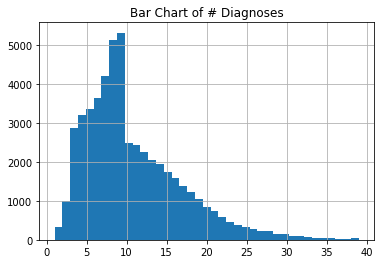

In [92]:
diagnoses_count.COUNT.hist(bins=39)
plt.title('Bar Chart of # Diagnoses')

Text(0.5,1,'Bar Chart of # Procedures')

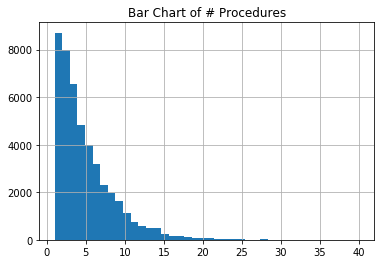

In [93]:
procedures_count.COUNT.hist(bins=40)
plt.title('Bar Chart of # Procedures')

Text(0.5,1,'1-year Mortality vs. # Diagnoses')

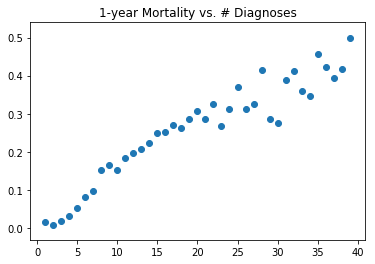

In [114]:
n_diag_mot1y = pd.merge(admits[['HADM_ID', 'MOT_1year']], diagnoses_count, on='HADM_ID').groupby('COUNT')['MOT_1year'].mean()
plt.scatter(n_diag_mot1y.index, n_diag_mot1y)
plt.title('1-year Mortality vs. # Diagnoses')

Text(0.5,1,'1-year Mortality vs. # Procedures')

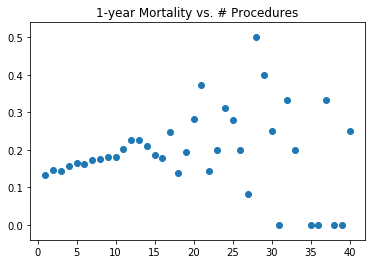

In [115]:
n_proc_mot1y = pd.merge(admits[['HADM_ID', 'MOT_1year']], procedures_count, on='HADM_ID').groupby('COUNT')['MOT_1year'].mean()
plt.scatter(n_proc_mot1y.index, n_proc_mot1y)
plt.title('1-year Mortality vs. # Procedures')

Text(0.5,1,'30-Days Mortality vs. # Diagnoses')

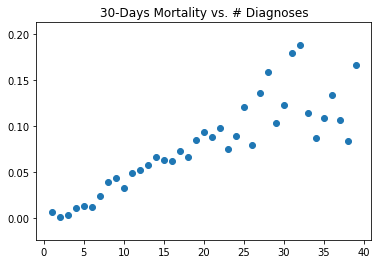

In [117]:
n_diag_mot30d = pd.merge(admits[['HADM_ID', 'MOT_30days']], diagnoses_count, on='HADM_ID').groupby('COUNT')['MOT_30days'].mean()
plt.scatter(n_diag_mot30d.index, n_diag_mot30d)
plt.title('30-Days Mortality vs. # Diagnoses')

Text(0.5,1,'30-Day Mortality vs. # Procedures')

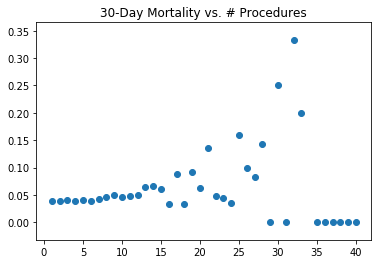

In [116]:
n_proc_mot30d = pd.merge(admits[['HADM_ID', 'MOT_30days']], procedures_count, on='HADM_ID').groupby('COUNT')['MOT_30days'].mean()
plt.scatter(n_proc_mot30d.index, n_proc_mot30d)
plt.title('30-Day Mortality vs. # Procedures')

Remove admissions with no codes: 

In [19]:
no_code = set(admits.HADM_ID).difference(set(diagnoses_count.HADM_ID).union(procedures_count.HADM_ID))
admits = admits.loc[~admits.HADM_ID.isin(no_code)]

Remove admissions with more than 20 procedures:

In [20]:
admits = admits.loc[~admits.HADM_ID.isin(set(procedures_count.loc[procedures_count.COUNT>20, 'HADM_ID']))]
procedures = procedures.loc[~procedures.HADM_ID.isin(set(procedures_count.loc[procedures_count.COUNT>20, 'HADM_ID']))]

In [21]:
admits.shape

(51697, 16)

Remove infrequent codes:

In [22]:
cutoff = 0

In [23]:
diag_freq = diagnoses.ICD9_CODE.value_counts()
proc_freq = procedures.ICD9_CODE.value_counts()
diag_freq = pd.DataFrame(dict(DX=diag_freq.index, frequency=diag_freq.values))
proc_freq = pd.DataFrame(dict(PR=proc_freq.index, frequency=proc_freq.values))

In [57]:
diag_freq.to_csv(data_path+'../cleaned/DX_freq.csv', index=False)
proc_freq.to_csv(data_path+'../cleaned/PR_freq.csv', index=False)

In [70]:
diagnoses.ICD9_CODE = diagnoses.ICD9_CODE.astype('str')
procedures.ICD9_CODE = procedures.ICD9_CODE.astype('str')

In [72]:
diagnoses_df = diagnoses.pivot_table(index='HADM_ID',columns=diagnoses.groupby('HADM_ID').cumcount(),values='ICD9_CODE',aggfunc=np.sum).add_prefix('DX')
procedures_df = procedures.pivot_table(index='HADM_ID',columns=procedures.groupby('HADM_ID').cumcount(),values='ICD9_CODE',aggfunc=np.sum).add_prefix('PR')

In [73]:
diagnoses_df.shape, procedures_df.shape, admits.shape

((51967, 39), (45443, 20), (51697, 16))

In [74]:
clean_df = pd.merge(admits[['SUBJECT_ID', 'HADM_ID', 'Eth', 'n_ICU_stays', 'ICU_LOS', 'GENDER', 'AGE', 'MOT_long', 'HOSP_LOS', 
                           'MOT_1year', 'MOT_30days']], diagnoses_df, on='HADM_ID', how='left')
clean_df = pd.merge(clean_df, procedures_df, on='HADM_ID', how='left')

In [75]:
clean_df.head()

SUBJECT_ID  HADM_ID  Eth  n_ICU_stays  ICU_LOS  GENDER        AGE  \
0          22   165315    4            1   1.1438       0  64.928145   
1          23   152223    4            1   1.2641       1  71.131651   
2          23   124321    4            1   1.1862       1  75.256344   
3          24   161859    4            1   0.5124       1  39.017027   
4          25   129635    4            1   3.5466       1  58.950115   

   MOT_long  HOSP_LOS  MOT_1year ...   PR10 PR11 PR12 PR13 PR14 PR15 PR16  \
0       NaN  1.144444      False ...    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1       NaN  5.496528      False ...    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2       NaN  6.768056      False ...    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3       NaN  2.856944      False ...    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4       NaN  3.534028      False ...    NaN  NaN  NaN  NaN  NaN  NaN  NaN   

  PR17 PR18 PR19  
0  NaN  NaN  NaN  
1  NaN  NaN  NaN  
2  NaN  NaN  NaN  
3  NaN  NaN  NaN  
4  NaN  NaN  NaN  

[5 rows x 70 columns]

In [77]:
clean_df.to_csv(data_path+'../cleaned/clean_df.csv', index=False)